In [ ]:
import os
import pandas as pd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler

import torchvision
import torchvision.transforms as transforms

import time

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


**Create Token in kaggle and upload the json file here**

In [ ]:
from google.colab import files
files.upload()  # Upload kaggle.json

Saving kaggle (1).json to kaggle (1).json


{'kaggle (1).json': b'{"username":"rajvinayakmeena","key":"8b8d0c30c4643047366386211ed3781a"}'}

**Download dataset directly from Kaggle**

In [ ]:
os.environ['KAGGLE_CONFIG_DIR'] = "/content/"
!pip install -q kaggle

# Download the dataset
!kaggle datasets download -d zalando-research/fashionmnist
!unzip -q fashionmnist.zip -d fashion-mnist

train_csv = pd.read_csv("fashion-mnist/fashion-mnist_train.csv")
test_csv = pd.read_csv("fashion-mnist/fashion-mnist_test.csv")

print(train_csv.head())
print(test_csv.head())

Dataset URL: https://www.kaggle.com/datasets/zalando-research/fashionmnist
License(s): other
 71% 49.0M/68.8M [00:00<00:00, 269MB/s]
100% 68.8M/68.8M [00:00<00:00, 248MB/s]
   label  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  pixel8  \
0      2       0       0       0       0       0       0       0       0   
1      9       0       0       0       0       0       0       0       0   
2      6       0       0       0       0       0       0       0       5   
3      0       0       0       0       1       2       0       0       0   
4      3       0       0       0       0       0       0       0       0   

   pixel9  ...  pixel775  pixel776  pixel777  pixel778  pixel779  pixel780  \
0       0  ...         0         0         0         0         0         0   
1       0  ...         0         0         0         0         0         0   
2       0  ...         0         0         0        30        43         0   
3       0  ...         3         0         0         0    

**CNN Model**

In [ ]:
num_classes = 10
learning_rate_cnn = 0.001
batch_size = 64
num_epochs_cnn = 10
validation_split = 0.1

class ImageDataset(Dataset):
    def __init__(self, csvdata, transform=None):
        self.dataset = list(csvdata.values)
        self.transform = transform

        labels = []
        images = []

        for row in self.dataset:
            labels.append(row[0])
            images.append(row[1:])
        self.labels = np.asarray(labels)
        self.images = np.asarray(images).reshape(-1, 28, 28, 1).astype('float32')

    def __getitem__(self, index):
        label = self.labels[index]
        image = self.images[index]

        if self.transform is not None:
            image = self.transform(image)

        return image, label

    def __len__(self):
        return len(self.images)

# Spliting the training data into train and val
num_train = len(train_csv)
indices = list(range(num_train))
split_idx = int(validation_split * num_train)
train_indices, val_indices = indices[split_idx:], indices[:split_idx]
train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

# Transforms
transform = transforms.Compose([transforms.ToTensor()])
train_set = ImageDataset(train_csv, transform=transform)
test_set = ImageDataset(test_csv, transform=transform)

train_loader = DataLoader(train_set, batch_size=batch_size, sampler=train_sampler)
val_loader = DataLoader(train_set, batch_size=batch_size, sampler=val_sampler)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

# Model:-
class ConvNet(nn.Module):
    def __init__(self, num_classes, feature_extraction=False):
        super(ConvNet, self).__init__()
        self.feature_extraction = feature_extraction

        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.layer3 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
        )

        self.layer4 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
        )

        self.layer5 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
        )

        self.fc1 = nn.Linear(in_features=7*7*128, out_features=128)
        self.drop = nn.Dropout2d(0.25)
        self.fc2 = nn.Linear(in_features=128, out_features=10)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)

        # Extract features here
        if self.feature_extraction:
            return out

        out = self.drop(out)
        out = self.fc2(out)
        return out

def train_cnn(model, data_loader, loss_criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0
    for images, labels in data_loader:
        images, labels = images.to(device), labels.to(device)
        labels = labels.type(torch.LongTensor).to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted_labels = torch.max(outputs, 1)
        total_samples += labels.size(0)
        correct_predictions += (predicted_labels == labels).sum().item()

    epoch_loss = running_loss / len(data_loader)
    epoch_accuracy = correct_predictions / total_samples
    return epoch_loss, epoch_accuracy

# Validation function
def validate_cnn(model, data_loader, loss_criterion, device):
    model.eval()  # Set to evaluation mode
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0
    with torch.no_grad():
      for images, labels in data_loader:
          images, labels = images.to(device), labels.to(device)
          labels = labels.type(torch.LongTensor).to(device)

          outputs = model(images)
          loss = loss_criterion(outputs, labels)
          running_loss += loss.item()

          _, predicted_labels = torch.max(outputs, 1)
          total_samples += labels.size(0)
          correct_predictions += (predicted_labels == labels).sum().item()

      epoch_loss = running_loss / len(data_loader)
      epoch_accuracy = correct_predictions / total_samples
      return epoch_loss, epoch_accuracy

# Test function
def test_cnn(model, data_loader, loss_criterion, device):
    model.eval()
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            labels = labels.type(torch.LongTensor).to(device)

            outputs = model(images)
            loss = loss_criterion(outputs, labels)
            running_loss += loss.item()

            _, predicted_labels = torch.max(outputs, 1)
            total_samples += labels.size(0)
            correct_predictions += (predicted_labels == labels).sum().item()

    test_loss = running_loss / len(data_loader)
    test_accuracy = correct_predictions / total_samples
    return test_loss, test_accuracy

# Initialize CNN
cnn_model = ConvNet(num_classes).to(device)
loss_criterion_cnn = nn.CrossEntropyLoss()
optimizer_cnn = optim.Adam(cnn_model.parameters(), lr=learning_rate_cnn)

# Training loop (CNN)
train_losses_cnn = []
val_losses_cnn = []
train_accuracies_cnn = []
val_accuracies_cnn = []
best_val_loss_cnn = np.inf

for epoch in range(num_epochs_cnn):
    train_start = time.time()
    train_loss, train_accuracy = train_cnn(cnn_model, train_loader, loss_criterion_cnn, optimizer_cnn, device)
    train_end = time.time()
    val_loss, val_accuracy = validate_cnn(cnn_model, val_loader, loss_criterion_cnn, device)
    val_end = time.time()
    print(f'Epoch [{epoch+1}/{num_epochs_cnn}], Train Time: {train_end-train_start}, Val Time: {val_end-train_start}')

    train_losses_cnn.append(train_loss)
    val_losses_cnn.append(val_loss)
    train_accuracies_cnn.append(train_accuracy)
    val_accuracies_cnn.append(val_accuracy)

    print(f'Epoch [{epoch+1}/{num_epochs_cnn}], Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}, Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}')

    if val_loss < best_val_loss_cnn:
      best_val_loss_cnn = val_loss
      # Save the best model weights based on validation accuracy here
      torch.save(cnn_model.state_dict(), 'best_cnn_val.pth')
      print(f"Validation loss improved! Best validation accuracy so far: {val_accuracy:.2f}, Best validation loss: {best_val_loss_cnn: .4f} (Model saved)")

print('Finished CNN Training')

/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:1538: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Epoch [1/10], Train Time: 9.74119758605957, Val Time: 10.048216342926025
Epoch [1/10], Train Loss: 0.4328, Train Acc: 0.85, Val Loss: 0.3236, Val Acc: 0.88
Validation loss improved! Best validation accuracy so far: 0.88, Best validation loss:  0.3236 (Model saved)
Epoch [2/10], Train Time: 9.994894981384277, Val Time: 10.182150602340698
Epoch [2/10], Train Loss: 0.2817, Train Acc: 0.90, Val Loss: 0.2860, Val Acc: 0.90
Validation loss improved! Best validation accuracy so far: 0.90, Best validation loss:  0.2860 (Model saved)
Epoch [3/10], Train Time: 4.54330039024353, Val Time: 4.7308149337768555
Epoch [3/10], Train Loss: 0.2377, Train Acc: 0.91, Val Loss: 0.2318, Val Acc: 0.92
Validation loss improved! Best validation accuracy so far: 0.92, Best validation loss:  0.2318 (Model saved)
Epoch [4/10], Train Time: 4.955825090408325, Val Time: 5.143384218215942
Epoch [4/10], Train Loss: 0.2095, Train Acc: 0.92, Val Loss: 0.2302, Val Acc: 0.92
Validation loss improved! Best validation accura

**Feature Extraction from CNN**

In [ ]:
def extract_features(model, data_loader, device):
    model.eval()
    features = []
    labels = []
    with torch.no_grad():
        for images, batch_labels in data_loader:
            images = images.to(device)
            batch_features = model(images)  # Get features from the CNN
            features.append(batch_features.cpu().numpy())
            labels.append(batch_labels.numpy())
    return np.concatenate(features), np.concatenate(labels)

In [ ]:
# Load the best CNN model
best_cnn_model = ConvNet(num_classes, feature_extraction=True).to(device)
best_cnn_model.load_state_dict(torch.load('best_cnn_val.pth'))

<ipython-input-7-5d5de4f8c9f5>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_cnn_model.load_state_dict(torch.load('best_cnn_val.pth'))


<All keys matched successfully>

In [ ]:
# Extract features for train,validation and test
cnn_train_features, train_labels_extracted = extract_features(best_cnn_model, train_loader, device)
cnn_val_features, val_labels_extracted = extract_features(best_cnn_model, val_loader, device)
cnn_test_features, test_labels_extracted = extract_features(best_cnn_model, test_loader, device)
print("CNN Features extracted")

CNN Features extracted


In [ ]:
# Standardizing the features helps in uniform scaling so MLP can learn better
def standardize(data, mean=None, std=None):
    if mean is None or std is None:
        mean = np.mean(data, axis=0)
        std = np.std(data, axis=0)

    # avoid the division by zero(0)
    std = np.where(std == 0, 1e-7, std)

    return (data - mean) / std, mean, std

cnn_train_features, train_mean, train_std = standardize(cnn_train_features)
cnn_val_features, _, _ = standardize(cnn_val_features, train_mean, train_std)
cnn_test_features, _, _ = standardize(cnn_test_features, train_mean, train_std)


**MLP using CNN extracted features**

In [ ]:
# Activation Functions and their Derivatives
def relu(x):
    return np.maximum(0, x)

def relu_derivative(x):
    return (x > 0).astype(float)

def softmax(x):
    exp_x = np.exp(x - np.max(x, axis=1, keepdims=True)) # For numerical stability
    return exp_x / np.sum(exp_x, axis=1, keepdims=True)

# Layer Classes
class LinearLayer:
    def __init__(self, input_size, output_size):
        self.W = np.random.randn(input_size, output_size) * np.sqrt(2.0 / input_size) # He initialization
        self.b = np.zeros((1, output_size))
        self.dW = None
        self.db = None
        self.input = None

    def forward(self, input_data):
        self.input = input_data
        return np.dot(input_data, self.W) + self.b

    def backward(self, output_gradient):
        self.dW = np.dot(self.input.T, output_gradient)
        self.db = np.sum(output_gradient, axis=0, keepdims=True)
        return np.dot(output_gradient, self.W.T)

    def update_params(self, learning_rate):
        if self.dW is not None:
            clip_value = 100.0
            self.dW = np.clip(self.dW, -clip_value, clip_value)
            self.db = np.clip(self.db, -clip_value, clip_value)
            self.W -= learning_rate * self.dW
            self.b -= learning_rate * self.db

class ReLU:
    def __init__(self):
        self.input = None

    def forward(self, input_data):
        self.input = input_data
        return relu(input_data)

    def backward(self, output_gradient):
        return output_gradient * relu_derivative(self.input)

class Dropout:
    def __init__(self, p):
        self.p = p
        self.mask = None
        self.train_mode = True

    def forward(self, input_data):
        if self.train_mode:
            self.mask = (np.random.rand(*input_data.shape) > self.p) / (1 - self.p) # Inverted dropout
            return input_data * self.mask
        else:
            return input_data # No dropout during inference

    def backward(self, output_gradient):
        return output_gradient * self.mask

In [ ]:
class MLP:
    def __init__(self, input_size, hidden_sizes, num_classes, activation_fn=ReLU, dropout_prob=0.1):
        self.layers = []
        layer_sizes = [input_size] + hidden_sizes + [num_classes]
        for i in range(len(layer_sizes) - 1):
            self.layers.append(LinearLayer(layer_sizes[i], layer_sizes[i+1]))
            if i < len(layer_sizes) - 2:
                self.layers.append(activation_fn())
                self.layers.append(Dropout(dropout_prob))
        self.train_mode = True

    def forward(self, x):
        output = x
        for layer in self.layers:
            if isinstance(layer, Dropout):
                layer.train_mode = self.train_mode
            output = layer.forward(output)
        return output

    def backward(self, output_gradient):
        gradient = output_gradient
        for layer in reversed(self.layers):
            gradient = layer.backward(gradient)

    def update_params(self, learning_rate):
        for layer in self.layers:
            if isinstance(layer, LinearLayer):
                layer.update_params(learning_rate)

    def predict_prob(self, x):
        self.train_mode = False
        output = self.forward(x)
        return softmax(output)

    def predict(self, x):
        probs = self.predict_prob(x)
        return np.argmax(probs, axis=1)

def cross_entropy_loss(predictions, labels_one_hot):
    m = labels_one_hot.shape[0]
    predictions = softmax(predictions)
    predictions_clipped = np.clip(predictions, 1e-12, 1 - 1e-12)
    loss = -np.sum(labels_one_hot * np.log(predictions_clipped)) / m
    return loss

def cross_entropy_loss_gradient(predictions, labels_one_hot):
    return (predictions - labels_one_hot) / predictions.shape[0]

In [ ]:
# Training parameters and setup
input_size_mlp = cnn_train_features.shape[1]
hidden_sizes_mlp = [512, 256, 128]
num_classes_mlp = 10
learning_rate_mlp = 0.01
num_epochs_mlp = 50
batch_size_mlp = 64
dropout_prob_mlp = 0.1

mlp_model = MLP(input_size_mlp, hidden_sizes_mlp, num_classes_mlp, ReLU, dropout_prob_mlp)

def one_hot_encode(labels, num_classes):
    return np.eye(num_classes)[labels]

# Training Loop (MLP)
history_train_loss_mlp = []
history_val_loss_mlp = []
history_test_loss_mlp = []
history_train_accuracy_mlp = []
history_val_accuracy_mlp = []
history_test_accuracy_mlp = []

num_train_data_mlp = cnn_train_features.shape[0]
num_batches_mlp = num_train_data_mlp // batch_size_mlp

num_validation_samples_mlp = cnn_val_features.shape[0]
num_validation_batches_mlp = num_validation_samples_mlp // batch_size_mlp

num_test_samples_mlp = cnn_test_features.shape[0]
num_test_batches_mlp = num_test_samples_mlp // batch_size_mlp

for epoch in range(num_epochs_mlp):
    mlp_model.train_mode = True
    epoch_train_loss_mlp = 0
    correct_train_predictions_mlp = 0

    permutation_mlp = np.random.permutation(cnn_train_features.shape[0])
    shuffled_train_data_mlp = cnn_train_features[permutation_mlp]
    shuffled_train_labels_mlp = train_labels_extracted[permutation_mlp]

    for batch_idx in range(num_batches_mlp):
        start_index_mlp = batch_idx * batch_size_mlp
        end_index_mlp = (batch_idx + 1) * batch_size_mlp
        batch_data_mlp = shuffled_train_data_mlp[start_index_mlp:end_index_mlp]
        batch_labels_mlp = shuffled_train_labels_mlp[start_index_mlp:end_index_mlp]

        labels_one_hot_mlp = one_hot_encode(batch_labels_mlp, num_classes_mlp)

        predictions_mlp = mlp_model.forward(batch_data_mlp)
        loss_mlp = cross_entropy_loss(predictions_mlp, labels_one_hot_mlp)
        epoch_train_loss_mlp += loss_mlp

        output_gradient_mlp = cross_entropy_loss_gradient(predictions_mlp, labels_one_hot_mlp)
        mlp_model.backward(output_gradient_mlp)
        mlp_model.update_params(learning_rate_mlp)

        predicted_labels_mlp = np.argmax(predictions_mlp, axis=1)
        correct_train_predictions_mlp += np.sum(predicted_labels_mlp == batch_labels_mlp)

    avg_epoch_train_loss_mlp = epoch_train_loss_mlp / num_batches_mlp
    train_accuracy_mlp = correct_train_predictions_mlp / cnn_train_features.shape[0] * 100

    # Validation Loop
    mlp_model.train_mode = False
    epoch_val_loss_mlp = 0
    correct_val_predictions_mlp = 0
    for batch_idx in range(num_validation_batches_mlp):
        start_index_mlp = batch_idx * batch_size_mlp
        end_index_mlp = (batch_idx + 1) * batch_size_mlp
        batch_data_mlp = cnn_val_features[start_index_mlp:end_index_mlp]
        batch_labels_mlp = val_labels_extracted[start_index_mlp:end_index_mlp]
        labels_one_hot_val_mlp = one_hot_encode(batch_labels_mlp, num_classes_mlp)
        predictions_val_mlp = mlp_model.forward(batch_data_mlp)
        loss_val_mlp = cross_entropy_loss(predictions_val_mlp, labels_one_hot_val_mlp)
        epoch_val_loss_mlp += loss_val_mlp
        predicted_val_labels_mlp = np.argmax(predictions_val_mlp, axis=1)
        correct_val_predictions_mlp += np.sum(predicted_val_labels_mlp == batch_labels_mlp)

    avg_epoch_val_loss_mlp = epoch_val_loss_mlp / num_validation_batches_mlp
    val_accuracy_mlp = correct_val_predictions_mlp / cnn_val_features.shape[0] * 100

    history_train_loss_mlp.append(avg_epoch_train_loss_mlp)
    history_val_loss_mlp.append(avg_epoch_val_loss_mlp)
    history_train_accuracy_mlp.append(train_accuracy_mlp)
    history_val_accuracy_mlp.append(val_accuracy_mlp)

    print(f'Epoch [{epoch+1}/{num_epochs_mlp}], Train Loss: {avg_epoch_train_loss_mlp:.4f}, Train Accuracy: {train_accuracy_mlp:.2f}%, Val Loss: {avg_epoch_val_loss_mlp:.4f}, Val Accuracy: {val_accuracy_mlp:.2f}%')



Epoch [1/50], Train Loss: 1.7239, Train Accuracy: 88.25%, Val Loss: 1.6750, Val Accuracy: 92.22%
Epoch [2/50], Train Loss: 1.6384, Train Accuracy: 93.96%, Val Loss: 1.6379, Val Accuracy: 92.55%
Epoch [3/50], Train Loss: 1.6193, Train Accuracy: 94.40%, Val Loss: 1.6329, Val Accuracy: 92.58%
Epoch [4/50], Train Loss: 1.6076, Train Accuracy: 94.74%, Val Loss: 1.6264, Val Accuracy: 92.62%
Epoch [5/50], Train Loss: 1.5997, Train Accuracy: 94.95%, Val Loss: 1.6236, Val Accuracy: 92.68%
Epoch [6/50], Train Loss: 1.5956, Train Accuracy: 95.13%, Val Loss: 1.6237, Val Accuracy: 92.72%
Epoch [7/50], Train Loss: 1.5917, Train Accuracy: 95.17%, Val Loss: 1.6202, Val Accuracy: 92.62%
Epoch [8/50], Train Loss: 1.5893, Train Accuracy: 95.10%, Val Loss: 1.6177, Val Accuracy: 92.83%
Epoch [9/50], Train Loss: 1.5858, Train Accuracy: 95.26%, Val Loss: 1.6191, Val Accuracy: 92.80%
Epoch [10/50], Train Loss: 1.5832, Train Accuracy: 95.34%, Val Loss: 1.6181, Val Accuracy: 92.80%
Epoch [11/50], Train Loss: 1.

In [ ]:
# Evaluation on Test Set
mlp_model.train_mode = False
test_loss_mlp = 0
correct_test_predictions_mlp = 0
for batch_idx in range(num_test_batches_mlp):
    start_index_mlp = batch_idx * batch_size_mlp
    end_index_mlp = (batch_idx + 1) * batch_size_mlp
    batch_data_mlp = cnn_test_features[start_index_mlp:end_index_mlp]
    batch_labels_mlp = test_labels_extracted[start_index_mlp:end_index_mlp]
    labels_one_hot_test_mlp = one_hot_encode(batch_labels_mlp, num_classes_mlp)
    predictions_test_mlp = mlp_model.forward(batch_data_mlp)
    loss_test_mlp = cross_entropy_loss(predictions_test_mlp, labels_one_hot_test_mlp)
    test_loss_mlp += loss_test_mlp
    predicted_test_labels_mlp = np.argmax(predictions_test_mlp, axis=1)
    correct_test_predictions_mlp += np.sum(predicted_test_labels_mlp == batch_labels_mlp)

avg_test_loss_mlp = test_loss_mlp / num_test_batches_mlp
test_accuracy_mlp = correct_test_predictions_mlp / cnn_test_features.shape[0] * 100
history_test_loss_mlp.append(avg_test_loss_mlp)
history_test_accuracy_mlp.append(test_accuracy_mlp)

print(f'Test Loss: {avg_test_loss_mlp:.4f}, Test Accuracy: {test_accuracy_mlp:.2f}%')

Test Loss: 1.6076, Test Accuracy: 92.97%


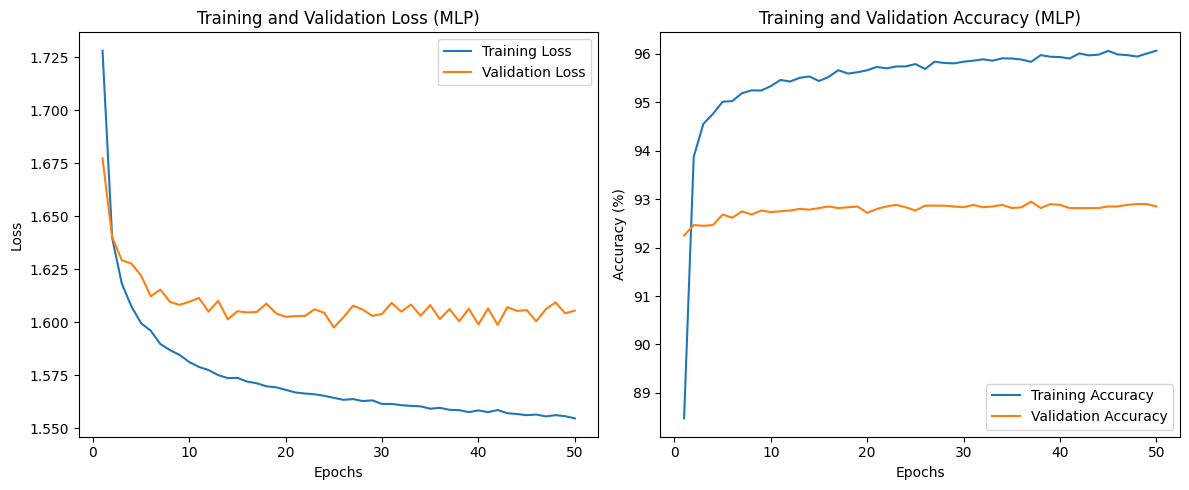


Final Test Accuracy (MLP): 92.97%


In [ ]:
# Plotting
epochs_range_mlp = range(1, num_epochs_mlp + 1)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range_mlp, history_train_loss_mlp, label='Training Loss')
plt.plot(epochs_range_mlp, history_val_loss_mlp, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss (MLP)')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range_mlp, history_train_accuracy_mlp, label='Training Accuracy')
plt.plot(epochs_range_mlp, history_val_accuracy_mlp, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy (MLP)')
plt.legend()

plt.tight_layout()
plt.show()

print(f"\nFinal Test Accuracy (MLP): {test_accuracy_mlp:.2f}%")